In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score




In [3]:
customer=pd.read_csv(r'C:\Users\alekh\Desktop\MMAI\datascience\python\assignment_2\CLV_Prediction\datasets\customers_final.csv')
engagement=pd.read_csv(r'C:\Users\alekh\Desktop\MMAI\datascience\python\assignment_2\CLV_Prediction\datasets\engagements_final.csv')
marketing=pd.read_csv(r'C:\Users\alekh\Desktop\MMAI\datascience\python\assignment_2\CLV_Prediction\datasets\marketing_final.csv')
transactions=pd.read_csv(r'C:\Users\alekh\Desktop\MMAI\datascience\python\assignment_2\CLV_Prediction\datasets\transactions_final.csv')

In [566]:
# customers table check
# this table holds demographic information and is at a CUSTOMER level
# it has 10,000 entries, as we have 10,000 customers
customer.head()

,customer_id,join_date,last_purchase_date,age,gender,location
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury
1,2,2021-09-08,2023-10-25,NaN,Male,Hillville
2,3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown
3,4,2022-01-01,2022-09-01,29.0,Male,Grossstad
4,5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort


In [567]:
# engagement table check
# this table holds aggregate CUSTOMER level data on the number of site visits, emails opened and clicks
# it also has 10,000 rows, one for each customer
engagement.head()

,customer_id,number_of_site_visits,number_of_emails_opened,number_of_clicks
0,1,10,15,1
1,2,285,49,51
2,3,192,73,25
3,4,110,30,17
4,5,161,2,7


In [568]:
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  int64  
 1   join_date           10000 non-null  object 
 2   last_purchase_date  10000 non-null  object 
 3   age                 8991 non-null   float64
 4   gender              9467 non-null   object 
 5   location            10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB


In [569]:
customer.isnull().sum()

customer_id              0
join_date                0
last_purchase_date       0
age                   1009
gender                 533
location                 0
dtype: int64

In [570]:
# marketing table check
# this table is at a CAMPAIGN ID level. It has 25,200 rows which means each customer will have MULTIPLE marketing offers
# this table captures if the customer responded to the offer or not
# Consider aggregating this table at a customer level (e.g., you could aggregate based on number of campaigns they responded YES to, or the most common campaign they responded to, etc.)
marketing.head()

,campaign_id,customer_id,response,promotion_type,campaign_date
0,1,1,No,Buy One Get One,2024-02-29
1,2,1,No,Discount,2024-01-24
2,3,1,No,Free Shipping,2024-03-05
3,4,1,Yes,Buy One Get One,2024-01-10
4,5,2,Yes,Free Shipping,2022-07-08


In [571]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   customer_id              10000 non-null  int64
 1   number_of_site_visits    10000 non-null  int64
 2   number_of_emails_opened  10000 non-null  int64
 3   number_of_clicks         10000 non-null  int64
dtypes: int64(4)
memory usage: 312.6 KB


In [572]:
engagement.isnull().sum()

customer_id                0
number_of_site_visits      0
number_of_emails_opened    0
number_of_clicks           0
dtype: int64

In [573]:
# marketing table check
# this table is at a CAMPAIGN ID level. It has 25,200 rows which means each customer will have MULTIPLE marketing offers
# this table captures if the customer responded to the offer or not

marketing.head()

,campaign_id,customer_id,response,promotion_type,campaign_date
0,1,1,No,Buy One Get One,2024-02-29
1,2,1,No,Discount,2024-01-24
2,3,1,No,Free Shipping,2024-03-05
3,4,1,Yes,Buy One Get One,2024-01-10
4,5,2,Yes,Free Shipping,2022-07-08


In [574]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   campaign_id     25200 non-null  int64 
 1   customer_id     25200 non-null  int64 
 2   response        25200 non-null  object
 3   promotion_type  25200 non-null  object
 4   campaign_date   25200 non-null  object
dtypes: int64(2), object(3)
memory usage: 984.5+ KB


In [575]:
marketing.isnull().sum()

campaign_id       0
customer_id       0
response          0
promotion_type    0
campaign_date     0
dtype: int64

In [576]:
# transaction data check
# this table is at a TRANSACTION ID level, and has 129,545 rows, meaning each customer has multiple transactions
transactions.head(20)

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
2,3,1,2024-03-12,146.86,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics
5,6,1,2024-01-09,174.72,Clothing
6,7,2,2022-05-05,443.99,Electronics
7,8,2,2023-01-03,492.16,Clothing
8,9,2,2021-12-11,910.21,Electronics
9,10,2,2022-10-20,42.29,Clothing


In [577]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129545 entries, 0 to 129544
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      129545 non-null  int64  
 1   customer_id         129545 non-null  int64  
 2   transaction_date    129545 non-null  object 
 3   transaction_amount  129545 non-null  float64
 4   product_category    129545 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.9+ MB


In [578]:
transactions.isnull().sum()

transaction_id        0
customer_id           0
transaction_date      0
transaction_amount    0
product_category      0
dtype: int64

age
gender
location
last purchase date
join date

we can whether customer making most purchase in which type of promotions
by  product type
transaction amount and promotion type


In [579]:
validation = missing_percentage >= 0.10

In [580]:
missing_percentage

gender          5.33
age            10.09
campaign_id    23.35
dtype: float64

FEAUTURE ENGINEERING

What the Metrics needed to be calculated for CLV
Find for the store and then per customer

Average Order Value =total sales/total orders 
Average Purchase Frequency or Transactions=Total orders/Total Customers
Average Customer value =Average order value x Average Purchase Frequency
Average Customer life span= Sum of customer Lifespan(first order-last order date) / total Customers
CLV= AVG customer value x  avg customer lifespan


In [581]:
# example 1: join at customer level with # of marketing campaigns customer responded YES to
# step 1: marketing data at a customer level

marketing_agg = marketing[marketing['response']=='Yes'].groupby('customer_id')['campaign_id'].count().to_frame()

In [582]:
marketing_agg

,campaign_id
customer_id,
1,1
2,2
3,1
4,1
6,1
...,...
9993,2
9994,2
9997,1


In [583]:
# step 2: aggregate transaction data at a customer level
transactions_agg = transactions.groupby('customer_id').aggregate({'transaction_id':'count','transaction_amount':'sum'})

In [584]:
transactions_agg

,transaction_id,transaction_amount
customer_id,,
1,6,3509.48
2,9,6081.32
3,6,1454.87
4,20,7874.68
5,24,15524.55
...,...,...
9996,10,5498.20
9997,12,5848.30
9998,3,3503.13


In [585]:
# step 3: set customers and engagement index as customer_id
customer.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)

In [586]:
engagement.head()

,number_of_site_visits,number_of_emails_opened,number_of_clicks
customer_id,,,
1,10,15,1
2,285,49,51
3,192,73,25
4,110,30,17
5,161,2,7


In [587]:
customer.head()

,join_date,last_purchase_date,age,gender,location
customer_id,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury
2,2021-09-08,2023-10-25,NaN,Male,Hillville
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown
4,2022-01-01,2022-09-01,29.0,Male,Grossstad
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort


In [588]:
# step 4: join all tables
joint_data = customer.join(engagement).join(transactions_agg).join(marketing_agg)

In [589]:
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,NaN,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,NaN,NaN,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,NaN,Male,East Matthewfort,161,2,7,24,15524.55,NaN


In [590]:
joint_data['age'].skew()

-0.0007142573102785624

In [591]:
joint_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10000 entries, 1 to 10000
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   join_date                10000 non-null  object 
 1   last_purchase_date       10000 non-null  object 
 2   age                      8991 non-null   float64
 3   gender                   9467 non-null   object 
 4   location                 10000 non-null  object 
 5   number_of_site_visits    10000 non-null  int64  
 6   number_of_emails_opened  10000 non-null  int64  
 7   number_of_clicks         10000 non-null  int64  
 8   transaction_id           10000 non-null  int64  
 9   transaction_amount       10000 non-null  float64
 10  campaign_id              7665 non-null   float64
dtypes: float64(3), int64(4), object(4)
memory usage: 937.5+ KB


In [592]:
# Identify the index positions of the 'gender' and 'age' columns
gender_index = joint_data.columns.get_loc('gender')
age_index = joint_data.columns.get_loc('age') 
campaign_index=joint_data.columns.get_loc('campaign_id') # Replace 'customer_age' with the correct column name for age if it's renamed

# Select the 'gender' and 'age' columns using iloc
selected_columns = joint_data.iloc[:, [gender_index, age_index,campaign_index]]

# Calculate the total number of missing values for these columns
missing_values = selected_columns.isnull().sum()

# Calculate the percentage of missing values for these columns
missing_percentage = (missing_values / len(joint_data)) * 100

# Create a DataFrame to display the results
missing_data = pd.DataFrame({
    'Total Missing': missing_values,
    'Percentage': missing_percentage,
    
})

In [593]:
print(missing_data)

             Total Missing  Percentage
gender                 533        5.33
age                   1009       10.09
campaign_id           2335       23.35


In [594]:

# Step 4: Replace missing values
joint_data.isnull().sum()


join_date                     0
last_purchase_date            0
age                        1009
gender                      533
location                      0
number_of_site_visits         0
number_of_emails_opened       0
number_of_clicks              0
transaction_id                0
transaction_amount            0
campaign_id                2335
dtype: int64

In [595]:
joint_data['age'].unique()

array([56., nan, 29., 55., 68., 49., 60., 23., 34., 58., 40., 25., 22.,
       20., 26., 61., 48., 65., 33., 64., 47., 59., 54., 44., 37., 27.,
       21., 19., 66., 31., 50., 46., 45., 62., 38., 18., 43., 41., 52.,
       67., 24., 28., 32., 35., 63., 51., 53., 39., 30., 42., 36., 69.,
       57.])

In [596]:
joint_data['age'].value_counts()

age
25.0    199
62.0    195
26.0    195
52.0    193
67.0    192
36.0    191
21.0    189
51.0    188
59.0    188
22.0    186
20.0    185
41.0    185
64.0    184
30.0    183
60.0    183
53.0    183
43.0    181
58.0    181
35.0    180
68.0    177
19.0    177
28.0    173
47.0    172
49.0    172
45.0    171
34.0    169
48.0    169
32.0    168
46.0    167
39.0    167
37.0    167
63.0    166
24.0    166
50.0    166
69.0    166
56.0    165
31.0    164
29.0    164
18.0    163
33.0    163
65.0    163
55.0    163
66.0    162
57.0    162
27.0    161
44.0    160
40.0    160
38.0    156
61.0    156
23.0    155
54.0    152
42.0    148
Name: count, dtype: int64

In [597]:
joint_data['age'].mode()

0    25.0
Name: age, dtype: float64

In [598]:
joint_data['age'] = joint_data['age'].fillna(value=joint_data['age'].mode()[0])

In [599]:
joint_data['gender'].mode()

0    Male
Name: gender, dtype: object

In [600]:
joint_data['gender'].value_counts()

gender
Male      4769
Female    4698
Name: count, dtype: int64

In [601]:
joint_data['gender'] = joint_data['gender'].fillna(value=joint_data['gender'].mode()[0])

In [602]:
joint_data['campaign_id'].value_counts()

campaign_id
1.0    4011
2.0    2563
3.0     923
4.0     168
Name: count, dtype: int64

In [603]:
joint_data['campaign_id'].fillna(np.nan, inplace=True)

C:\Users\alekh\AppData\Local\Temp\ipykernel_119800\2559459164.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  joint_data['campaign_id'].fillna(np.nan, inplace=True)


In [604]:
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id
customer_id,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,3509.48,1.0
2,2021-09-08,2023-10-25,25.0,Male,Hillville,285,49,51,9,6081.32,2.0
3,2021-06-01,2022-11-27,25.0,Male,North Latoyatown,192,73,25,6,1454.87,1.0
4,2022-01-01,2022-09-01,29.0,Male,Grossstad,110,30,17,20,7874.68,1.0
5,2022-01-24,2023-06-02,25.0,Male,East Matthewfort,161,2,7,24,15524.55,NaN


In [605]:
#to find  the avg Order value per transaction of each customer
joint_data['AvgOrderVal'] =  joint_data['transaction_amount'] / joint_data['transaction_id']


In [606]:
joint_data['age'].median()

41.0

In [607]:
joint_data['age'] = joint_data['age'].astype(int)

joint_data['AvgOrderVal'] = joint_data['AvgOrderVal'].round().astype(int)
joint_data['transaction_amount'] = joint_data['transaction_amount'].round().astype(int)


In [681]:
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,customer_lifespan_days,Customerlifetime_Years,recency,frequency,monetary,r_rank,f_rank,m_rank,rfm_score,rfm_segment
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,1,North Shannonbury,10,15,1,6,3509,...,118,1,111,6,3509.48,5,1,2,512,Loyal Customers
2,2021-09-08,2023-10-25,25,0,Hillville,285,49,51,9,6081,...,777,3,491,9,6081.32,3,2,3,323,Others
3,2021-06-01,2022-11-27,25,0,North Latoyatown,192,73,25,6,1455,...,544,2,591,6,1454.87,2,1,1,211,Others
4,2022-01-01,2022-09-01,29,0,Grossstad,110,30,17,20,7875,...,243,1,670,20,7874.68,2,4,3,243,Others
5,2022-01-24,2023-06-02,25,0,East Matthewfort,161,2,7,24,15525,...,494,2,396,24,15524.55,3,5,5,355,Frequent Customers


In [609]:
transactions.head()

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
2,3,1,2024-03-12,146.86,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics


C:\Users\alekh\AppData\Local\Temp\ipykernel_119800\784123436.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='product_category',y='transaction_amount',data=transactions,palette='tab10')


([0, 1, 2],
 [Text(0, 0, 'Clothing'), Text(1, 0, 'Home Goods'), Text(2, 0, 'Electronics')])

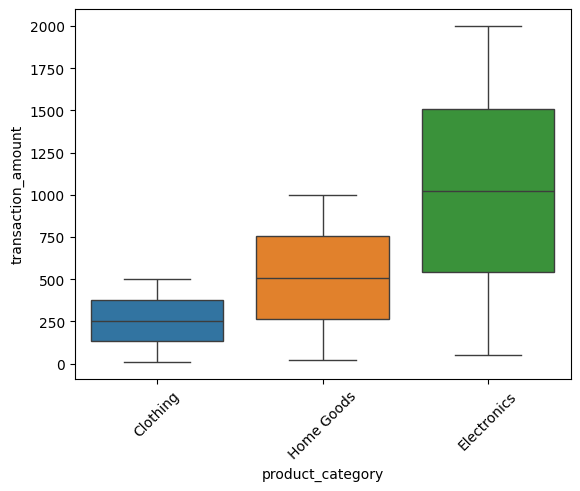

In [610]:
#To check whether the avg val increased with the increase of campaign response
sns.boxplot(x='product_category',y='transaction_amount',data=transactions,palette='tab10')
plt.xticks(rotation=45)

In [611]:
transactions['product_category'].unique()

array(['Clothing', 'Home Goods', 'Electronics'], dtype=object)

In [612]:
transactions['product_category'].value_counts()

product_category
Electronics    43460
Clothing       43240
Home Goods     42845
Name: count, dtype: int64

In [613]:
#lets find the Average purcghase frequency on the Avg of the customers
Average_purchase_frequency=joint_data['transaction_id'].mean()
#joint_data['Average_purchase_frequency'] = joint_data['Average_purchase_frequency'].round().astype(int)


In [614]:
Average_purchase_frequency

12.9545

In [615]:
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,AvgOrderVal
customer_id,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,Female,North Shannonbury,10,15,1,6,3509,1.0,585
2,2021-09-08,2023-10-25,25,Male,Hillville,285,49,51,9,6081,2.0,676
3,2021-06-01,2022-11-27,25,Male,North Latoyatown,192,73,25,6,1455,1.0,242
4,2022-01-01,2022-09-01,29,Male,Grossstad,110,30,17,20,7875,1.0,394
5,2022-01-24,2023-06-02,25,Male,East Matthewfort,161,2,7,24,15525,NaN,647


On average, each customer made approximately 13 purchases.
Distribution: Some customers may have made fewer purchases, while others may have made more. The average helps to understand the overall purchasing behavior in your dataset.

In [616]:
#Average Customer life span
# Convert 'first_order_date' and 'last_order_date' to datetime (replace with your actual column names)
joint_data['join_date'] = pd.to_datetime(joint_data['join_date'])
joint_data['last_purchase_date'] = pd.to_datetime(joint_data['last_purchase_date'])

# Calculate the lifespan for each customer
joint_data['customer_lifespan_days'] = (joint_data['last_purchase_date'] - joint_data['join_date']).dt.days



In [617]:
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,AvgOrderVal,customer_lifespan_days
customer_id,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,Female,North Shannonbury,10,15,1,6,3509,1.0,585,118
2,2021-09-08,2023-10-25,25,Male,Hillville,285,49,51,9,6081,2.0,676,777
3,2021-06-01,2022-11-27,25,Male,North Latoyatown,192,73,25,6,1455,1.0,242,544
4,2022-01-01,2022-09-01,29,Male,Grossstad,110,30,17,20,7875,1.0,394,243
5,2022-01-24,2023-06-02,25,Male,East Matthewfort,161,2,7,24,15525,NaN,647,494


In [618]:
joint_data['customer_lifespan_days'].max()

1583

In [619]:
def Customerlifetime_Years(x):
    if x>=0 and x<=366:
        return '1'
    elif x>=366 and x<=730:
         return '2'
    elif x>=731 and x<=1095:
         return '3'
    elif x>=1096 and x<=1460:
         return '4'
    else:
        return '5'

In [620]:
joint_data['Customerlifetime_Years'] = joint_data['customer_lifespan_days'].apply(Customerlifetime_Years)

In [621]:
#converting categorical gender values into binary
mapping = {'Male': 0, 'Female': 1, 'unknown': -1}  # Assuming -1 for unknown values
joint_data['gender'] = joint_data['gender'].map(mapping)

In [622]:
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,campaign_id,AvgOrderVal,customer_lifespan_days,Customerlifetime_Years
customer_id,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,1,North Shannonbury,10,15,1,6,3509,1.0,585,118,1
2,2021-09-08,2023-10-25,25,0,Hillville,285,49,51,9,6081,2.0,676,777,3
3,2021-06-01,2022-11-27,25,0,North Latoyatown,192,73,25,6,1455,1.0,242,544,2
4,2022-01-01,2022-09-01,29,0,Grossstad,110,30,17,20,7875,1.0,394,243,1
5,2022-01-24,2023-06-02,25,0,East Matthewfort,161,2,7,24,15525,NaN,647,494,2


C:\Users\alekh\AppData\Local\Temp\ipykernel_119800\3855950432.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Customerlifetime_Years',y='AvgOrderVal',data=joint_data,palette='tab10')


([0, 1, 2, 3, 4],
 [Text(0, 0, '1'),
  Text(1, 0, '3'),
  Text(2, 0, '2'),
  Text(3, 0, '4'),
  Text(4, 0, '5')])

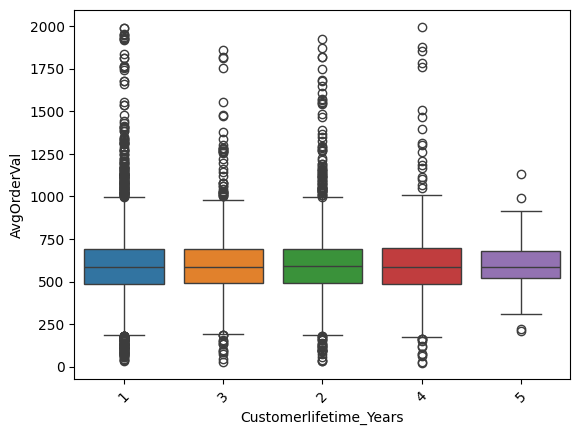

In [623]:
sns.boxplot(x='Customerlifetime_Years',y='AvgOrderVal',data=joint_data,palette='tab10')
plt.xticks(rotation=45)

In [624]:
transactions.head()

,transaction_id,customer_id,transaction_date,transaction_amount,product_category
0,1,1,2024-02-03,165.56,Clothing
1,2,1,2024-03-02,699.01,Home Goods
2,3,1,2024-03-12,146.86,Home Goods
3,4,1,2024-01-20,927.46,Electronics
4,5,1,2024-02-25,1395.87,Electronics


In [625]:

# Convert 'transaction_date' to datetime (replace with your actual column name)
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])

# Define the reference date for recency calculation
reference_date = pd.Timestamp('2024-07-01')

In [626]:
# Calculate Recency, Frequency, and Monetary value
rfm_df = transactions.groupby('customer_id').agg({
    'transaction_date': lambda x: (reference_date - x.max()).days,
    'transaction_id': 'count',
    'transaction_amount': 'sum'
}).reset_index()

In [627]:
# Rename columns for clarity
rfm_df.rename(columns={
    'transaction_date': 'recency',
    'transaction_id': 'frequency',
    'transaction_amount': 'monetary'
}, inplace=True)

In [628]:
# Rank customers based on Recency, Frequency, and Monetary value
rfm_df['r_rank'] = pd.qcut(rfm_df['recency'], 5, labels=[5, 4, 3, 2, 1])
rfm_df['f_rank'] = pd.qcut(rfm_df['frequency'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])
rfm_df['m_rank'] = pd.qcut(rfm_df['monetary'].rank(method='first'), 5, labels=[1, 2, 3, 4, 5])


In [629]:
# Calculate RFM score
rfm_df['rfm_score'] = rfm_df['r_rank'].astype(str) + rfm_df['f_rank'].astype(str) + rfm_df['m_rank'].astype(str)

In [630]:
rfm_df.head()

,customer_id,recency,frequency,monetary,r_rank,f_rank,m_rank,rfm_score
0,1,111,6,3509.48,5,1,2,512
1,2,491,9,6081.32,3,2,3,323
2,3,591,6,1454.87,2,1,1,211
3,4,670,20,7874.68,2,4,3,243
4,5,396,24,15524.55,3,5,5,355


In [631]:
# Define RFM segments
def rfm_segment(row):
    if row['rfm_score'] == '555':
        return 'Best Customers'
    elif row['rfm_score'][0] == '5':
        return 'Loyal Customers'
    elif row['rfm_score'][1] == '5':
        return 'Frequent Customers'
    elif row['rfm_score'][2] == '5':
        return 'Big Spenders'
    elif row['rfm_score'] == '111':
        return 'At Risk'
    else:
        return 'Others'

rfm_df['rfm_segment'] = rfm_df.apply(rfm_segment, axis=1)


In [632]:
# Convert 'age' from object to int
joint_data['Customerlifetime_Years'] = joint_data['Customerlifetime_Years'].astype(int)
rfm_df['r_rank'] = rfm_df['r_rank'].astype(int)
rfm_df['f_rank'] = rfm_df['f_rank'].astype(int)
rfm_df['m_rank'] = rfm_df['m_rank'].astype(int)

In [633]:
# Merge the original dataset with the RFM DataFrame
joint_data = joint_data.merge(rfm_df, on='customer_id', how='left')

In [634]:
rfm_df.head()

,customer_id,recency,frequency,monetary,r_rank,f_rank,m_rank,rfm_score,rfm_segment
0,1,111,6,3509.48,5,1,2,512,Loyal Customers
1,2,491,9,6081.32,3,2,3,323,Others
2,3,591,6,1454.87,2,1,1,211,Others
3,4,670,20,7874.68,2,4,3,243,Others
4,5,396,24,15524.55,3,5,5,355,Frequent Customers


In [635]:
joint_data = joint_data.set_index('customer_id')

In [636]:
joint_data.head()

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_amount,...,customer_lifespan_days,Customerlifetime_Years,recency,frequency,monetary,r_rank,f_rank,m_rank,rfm_score,rfm_segment
customer_id,,,,,,,,,,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56,1,North Shannonbury,10,15,1,6,3509,...,118,1,111,6,3509.48,5,1,2,512,Loyal Customers
2,2021-09-08,2023-10-25,25,0,Hillville,285,49,51,9,6081,...,777,3,491,9,6081.32,3,2,3,323,Others
3,2021-06-01,2022-11-27,25,0,North Latoyatown,192,73,25,6,1455,...,544,2,591,6,1454.87,2,1,1,211,Others
4,2022-01-01,2022-09-01,29,0,Grossstad,110,30,17,20,7875,...,243,1,670,20,7874.68,2,4,3,243,Others
5,2022-01-24,2023-06-02,25,0,East Matthewfort,161,2,7,24,15525,...,494,2,396,24,15524.55,3,5,5,355,Frequent Customers


In [637]:
rfm_df['rfm_segment'].value_counts()

rfm_segment
Others                5560
Loyal Customers       1672
Frequent Customers    1541
At Risk                468
Big Spenders           431
Best Customers         328
Name: count, dtype: int64

In [638]:
# Segment Analysis
segments = rfm_df['rfm_segment'].unique()

for segment in segments:
    segment_df = rfm_df[rfm_df['rfm_segment'] == segment]
    print(f"\nSegment: {segment}")
    print(f"Number of Customers: {segment_df.shape[0]}")
    print(f"Average Recency: {segment_df['recency'].mean()}")
    print(f"Average Frequency: {segment_df['frequency'].mean()}")
    print(f"Average Monetary Value: {segment_df['monetary'].mean()}")
    print(f"Total Monetary Value: {segment_df['monetary'].sum()}")


Segment: Loyal Customers
Number of Customers: 1672
Average Recency: 86.20454545454545
Average Frequency: 12.273325358851675
Average Monetary Value: 7192.178397129187
Total Monetary Value: 12025322.280000001

Segment: Others
Number of Customers: 5560
Average Recency: 542.0494604316547
Average Frequency: 10.238489208633094
Average Monetary Value: 5942.795830935252
Total Monetary Value: 33041944.82

Segment: Frequent Customers
Number of Customers: 1541
Average Recency: 566.1012329656068
Average Frequency: 22.951330304996755
Average Monetary Value: 13621.44287475665
Total Monetary Value: 20990643.47

Segment: Big Spenders
Number of Customers: 431
Average Recency: 561.1183294663573
Average Frequency: 18.389791183294662
Average Monetary Value: 13542.473735498841
Total Monetary Value: 5836806.180000001

Segment: At Risk
Number of Customers: 468
Average Recency: 1072.66452991453
Average Frequency: 2.47008547008547
Average Monetary Value: 1290.773824786325
Total Monetary Value: 604082.15

Segm

Recency: Helps identify how recently customers are engaging with your business. More recent activity suggests higher engagement and likelihood of future purchases.
Frequency: Indicates how often customers are purchasing from you. Higher frequency means more loyal and regular customers.
Monetary: Shows how much customers are spending. Higher spending indicates higher value customers who contribute more to your revenue.
Number of Customers: Provides an understanding of the size of each segment, helping to prioritize marketing efforts and resource allocation.
Total Monetary Value: Gives a sense of the revenue contribution of each segment, highlighting the financial importance of retaining and nurturing these customers.

By analyzing these metrics for different segments, you can develop targeted marketing strategies, improve customer retention, and increase overall revenue. For example, you might want to provide special rewards or personalized offers to your "Best Customers" to maintain their loyalty and encourage further spending.

Text(0, 0.5, 'Frequency')

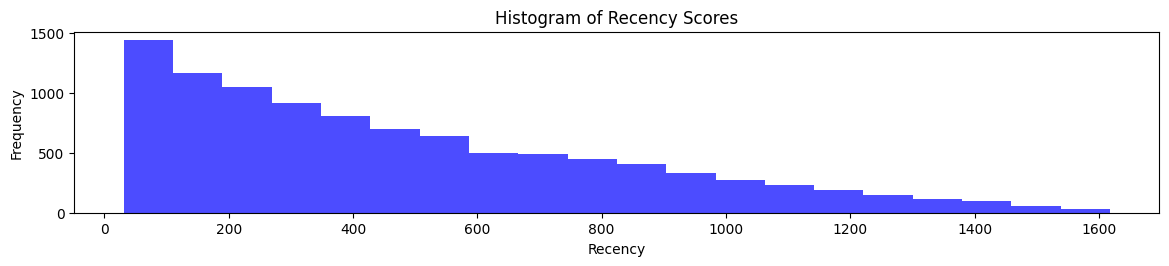

In [639]:
# Plot histograms of RFM scores
plt.figure(figsize=(14, 8))
# Recency
plt.subplot(3, 1, 1)
rfm_df['recency'].plot(kind='hist', bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Recency Scores')
plt.xlabel('Recency')
plt.ylabel('Frequency')

C:\Users\alekh\AppData\Local\Temp\ipykernel_119800\4258926063.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(rfm_df['recency'], shade=True, color='blue')


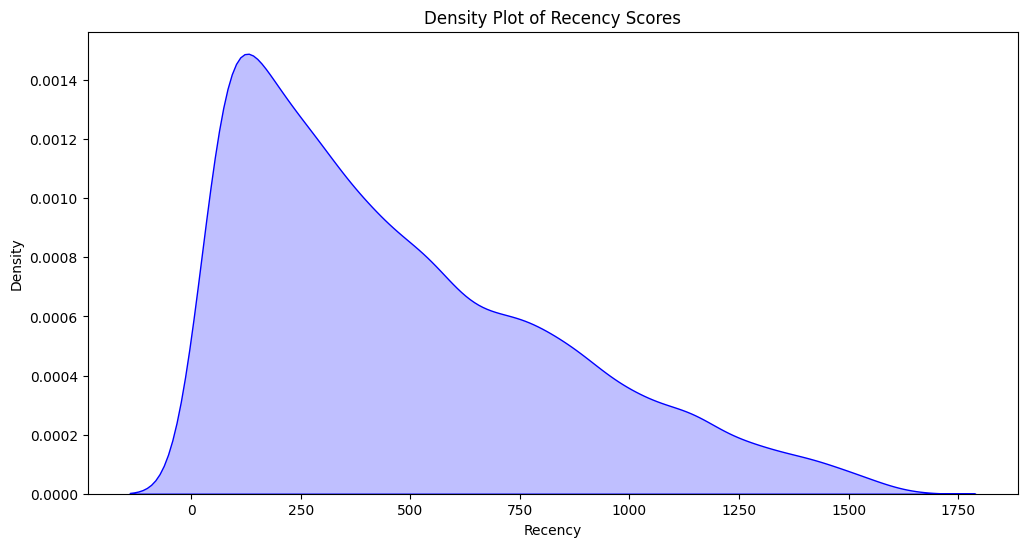

In [640]:
# Plot Density Plot
plt.figure(figsize=(12, 6))
sns.kdeplot(rfm_df['recency'], shade=True, color='blue')
plt.title('Density Plot of Recency Scores')
plt.xlabel('Recency')
plt.ylabel('Density')
plt.show()

C:\Users\alekh\AppData\Local\Temp\ipykernel_119800\689173777.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rfm_segment', y='monetary', data=joint_data, ax=ax1,palette='tab10')
C:\Users\alekh\AppData\Local\Temp\ipykernel_119800\689173777.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rfm_segment',y='campaign_id',data=joint_data, ax=ax2,palette='tab10')
C:\Users\alekh\AppData\Local\Temp\ipykernel_119800\689173777.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rfm_segment',y='number_of_site_visits',data=joint_data, ax=a

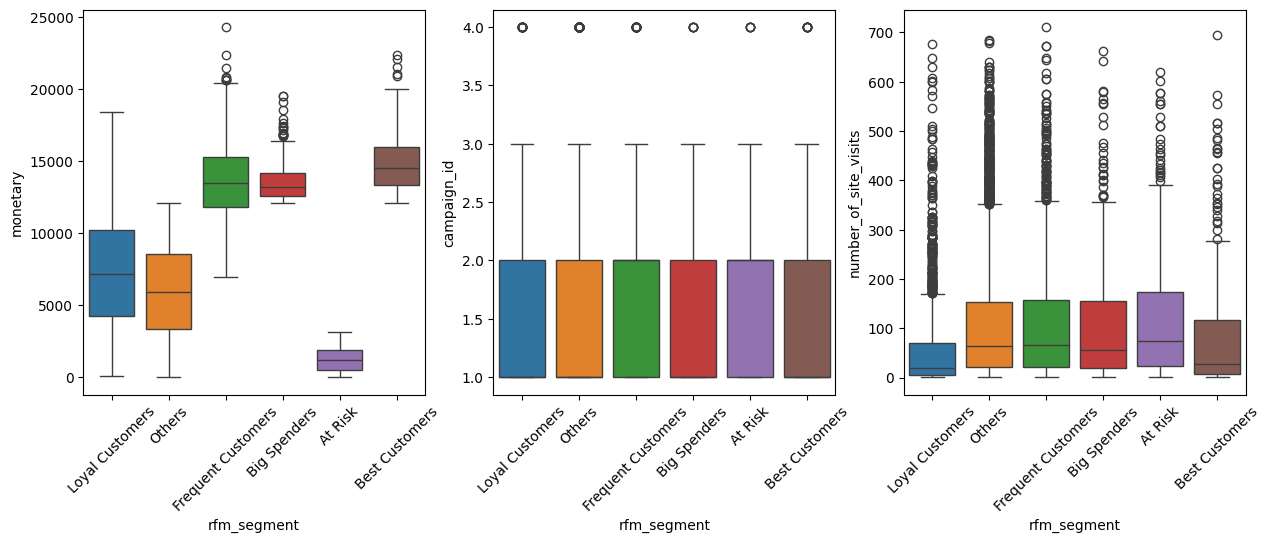

In [641]:
fig, (ax1,ax2, ax3) = plt.subplots(1,3, figsize = (15,5), sharey=False)
sns.boxplot(x='rfm_segment', y='monetary', data=joint_data, ax=ax1,palette='tab10')

sns.boxplot(x='rfm_segment',y='campaign_id',data=joint_data, ax=ax2,palette='tab10')

sns.boxplot(x='rfm_segment',y='number_of_site_visits',data=joint_data, ax=ax3,palette='tab10')
# Rotate x-axis labels for each subplot
for ax in [ax1, ax2, ax3]:
    for label in ax.get_xticklabels():
        label.set_rotation(45)





every customer as reacted to min 1 -2 campaigns ,loyal and best customers even though they visit the site very less times they make huge purchases 

C:\Users\alekh\AppData\Local\Temp\ipykernel_119800\312259988.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='rfm_segment', y='transaction_id', data=joint_data, ax=ax3, palette='viridis')
C:\Users\alekh\AppData\Local\Temp\ipykernel_119800\312259988.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)


[Text(0, 0, 'Loyal Customers'),
 Text(1, 0, 'Others'),
 Text(2, 0, 'Frequent Customers'),
 Text(3, 0, 'Big Spenders'),
 Text(4, 0, 'At Risk'),
 Text(5, 0, 'Best Customers')]

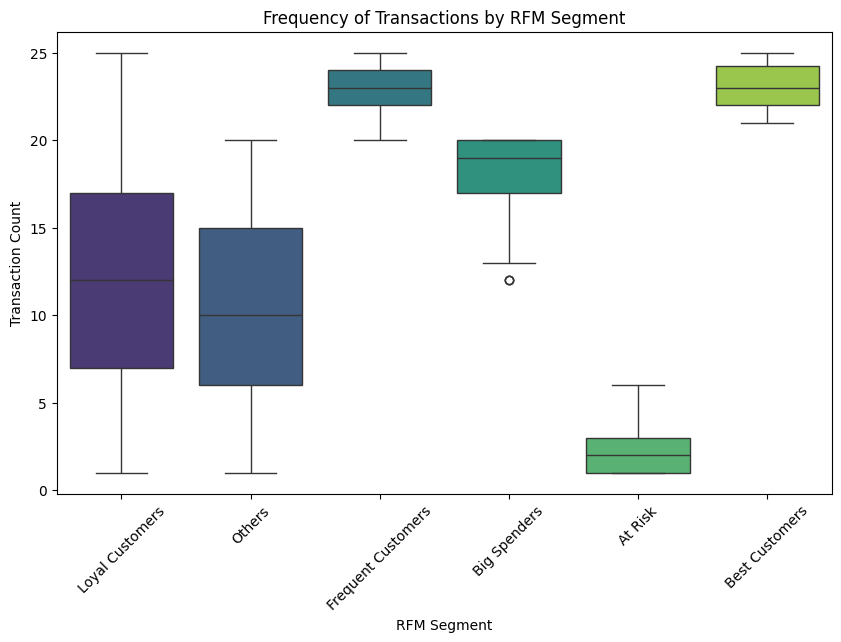

In [642]:


fig, ax3 = plt.subplots(1, 1, figsize=(10, 6))

# Plot frequency of transactions
sns.boxplot(x='rfm_segment', y='transaction_id', data=joint_data, ax=ax3, palette='viridis')
ax3.set_title('Frequency of Transactions by RFM Segment')
ax3.set_xlabel('RFM Segment')
ax3.set_ylabel('Transaction Count')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)

LINEAR REGRESSION :Predicting the total purchase amount (monetary value) for a customer based on their RFM scores

In [643]:
column_toDrop=[
    'join_date', 'last_purchase_date', 'transaction_id',
    'location', 'rfm_score', 'rfm_segment','f_rank','Customerlifetime_Years'
    ,'r_rank','m_rank','transaction_amount','gender'
]

In [644]:
model_data = joint_data.drop(columns=column_toDrop)

In [645]:
model_data

,age,number_of_site_visits,number_of_emails_opened,number_of_clicks,campaign_id,AvgOrderVal,customer_lifespan_days,recency,frequency,monetary
customer_id,,,,,,,,,,
1,56,10,15,1,1.0,585,118,111,6,3509.48
2,25,285,49,51,2.0,676,777,491,9,6081.32
3,25,192,73,25,1.0,242,544,591,6,1454.87
4,29,110,30,17,1.0,394,243,670,20,7874.68
5,25,161,2,7,NaN,647,494,396,24,15524.55
...,...,...,...,...,...,...,...,...,...,...
9996,42,119,47,16,NaN,550,240,386,10,5498.20
9997,26,3,33,14,1.0,487,200,571,12,5848.30
9998,39,53,17,5,1.0,1168,135,182,3,3503.13


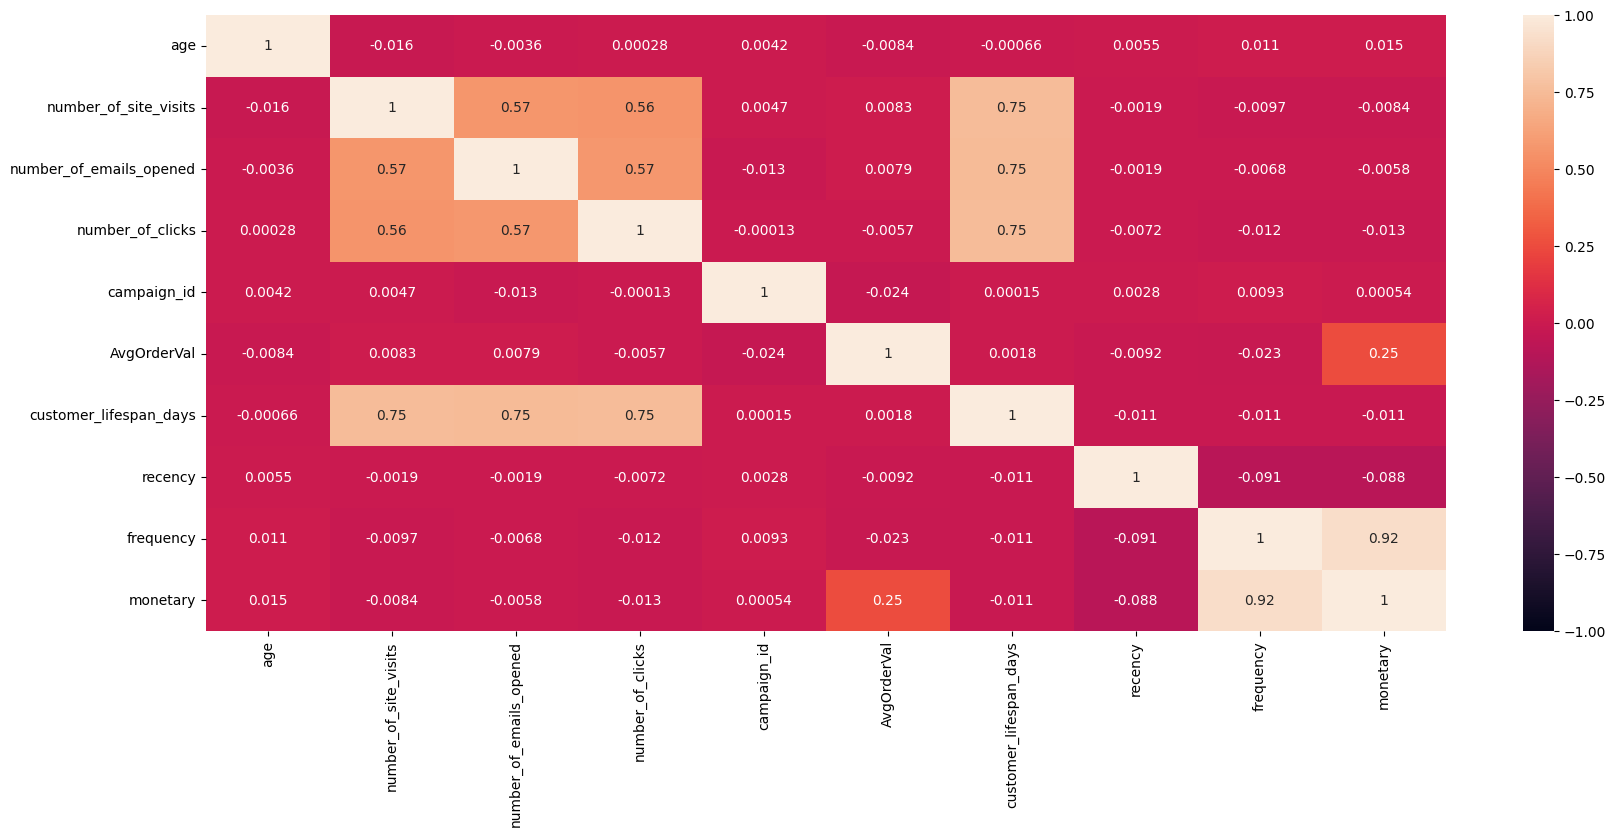

In [646]:
plt.figure(figsize=(20, 8))
sns.heatmap(model_data.corr(), annot=True, vmin=-1, vmax=1)

plt.show()

Divide the data into training and testing sets.

In [647]:
features = [
    'age',  'number_of_site_visits', 'number_of_emails_opened',
                    'number_of_clicks', 'AvgOrderVal', 'customer_lifespan_days',
                    'recency', 'frequency','campaign_id'
]
target = 'monetary'

In [648]:
# Handle missing values in 'campaign_id' by filling with a placeholder value (e.g., 0 or -1)
model_data['campaign_id'].fillna(-1, inplace=True)

C:\Users\alekh\AppData\Local\Temp\ipykernel_119800\1180107660.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  model_data['campaign_id'].fillna(-1, inplace=True)


In [649]:
X = model_data[features]
y = model_data[target]

In [650]:
# Handle any missing values (if needed)
X = X.fillna(X.mean())

In [651]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [652]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7000, 9), (3000, 9), (7000,), (3000,))

Create a pipeline for data preprocessing and model training.

In [653]:
# Create a formula for OLS regression
formula = f'{target} ~ ' + ' + '.join(features)

# Perform OLS regression using the formula API
results = smf.ols(formula=formula, data=model_data).fit()

# Print the model summary
print(results.summary())


                            OLS Regression Results                            
Dep. Variable:               monetary   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 1.378e+04
Date:                Tue, 16 Jul 2024   Prob (F-statistic):               0.00
Time:                        13:01:16   Log-Likelihood:                -85608.
No. Observations:               10000   AIC:                         1.712e+05
Df Residuals:                    9990   BIC:                         1.713e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -3

Dependant Variable: monetary
R-squared: 0.958
This indicates that 95.8% of the variance in the monetary value can be explained by the model.
Adj. R-squared: 0.958
Adjusted R-squared accounts for the number of predictors in the model and is very close to the R-squared value, indicating a good fit.


Based on the statistical significance from the OLS results, the following features should be considered for the monetary value model:

age
frequency
f_rank
m_rank
AvgOrderVal

In [654]:
# Create a formula for OLS regression
formula = f'{target} ~ ' + ' + '.join(features)

# Perform OLS regression using the formula API
results = smf.ols(formula=formula, data=model_data).fit()

# Print the model summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               monetary   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 1.378e+04
Date:                Tue, 16 Jul 2024   Prob (F-statistic):               0.00
Time:                        13:01:16   Log-Likelihood:                -85608.
No. Observations:               10000   AIC:                         1.712e+05
Df Residuals:                    9990   BIC:                         1.713e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept               -3

In [655]:
results_formula = smf.ols(formula=formula, data=model_data).fit()
predicted_vals_formula = results_formula.predict(model_data[features])

In [656]:
# Define significant features and target variable
significant_features = ['age', 'frequency', 'AvgOrderVal']
target = 'monetary'

X = model_data[significant_features]
y = model_data[target]

# Handle any missing values (if needed)
X = X.fillna(X.mean())

# Add a constant to the model (intercept)
X_const = sm.add_constant(X)

# Perform OLS regression
ols_model = sm.OLS(y, X_const).fit()

# Print the model summary
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:               monetary   R-squared:                       0.925
Model:                            OLS   Adj. R-squared:                  0.925
Method:                 Least Squares   F-statistic:                 4.135e+04
Date:                Tue, 16 Jul 2024   Prob (F-statistic):               0.00
Time:                        13:01:16   Log-Likelihood:                -85609.
No. Observations:               10000   AIC:                         1.712e+05
Df Residuals:                    9996   BIC:                         1.713e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -3919.1013     58.094    -67.461      

In [657]:
# Predict values using the feature-based model
predicted_vals_features = ols_model.predict(X_const)

# Display the first few predicted values

print(predicted_vals_features.head(10))

customer_id
1      3511.867628
2      5827.765583
3      1261.915165
4     10611.508633
5     14611.581898
6     10202.228756
7       830.045838
8     10168.079285
9     12379.991160
10     -247.317874
dtype: float64


In [658]:
residuals = joint_data['monetary'] - predicted_vals_features

In [659]:
residuals.mean()

-2.650704118423164e-11

Residuals

<Axes: ylabel='Count'>

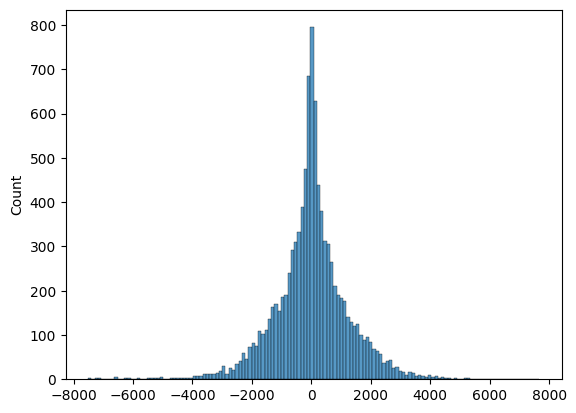

In [660]:
sns.histplot(residuals)

In [661]:
# Fit and predict using LinearRegression
logreg = LinearRegression()
logreg.fit(X_train, y_train)
y_pred_logreg = logreg.predict(X_test)

In [662]:
# Regression metrics for LinearRegression


from sklearn.metrics import r2_score


mae_logreg = mean_absolute_error(y_test, y_pred_logreg)
mse_logreg = mean_squared_error(y_test, y_pred_logreg)
rmse_logreg = np.sqrt(mse_logreg)
r2_logreg = r2_score(y_test, y_pred_logreg)

print(f'Linear Regression - Mean Absolute Error (MAE): {mae_logreg}')
print(f'Linear Regression - Mean Squared Error (MSE): {mse_logreg}')
print(f'Linear Regression - Root Mean Squared Error (RMSE): {rmse_logreg}')
print(f'Linear Regression - R-squared: {r2_logreg}')


Linear Regression - Mean Absolute Error (MAE): 867.5950045209202
Linear Regression - Mean Squared Error (MSE): 1593056.452131808
Linear Regression - Root Mean Squared Error (RMSE): 1262.1634015181266
Linear Regression - R-squared: 0.9247356715855222


In [670]:
# Normalize the features for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [675]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsRegressor(n_neighbors=5))
])

In [671]:
# Fit the KNN regression model
knn_regressor = KNeighborsRegressor(n_neighbors=5)  # You can adjust the number of neighbors
knn_regressor.fit(X_train_scaled, y_train)

KNeighborsRegressor()

In [676]:
# Use cross-validation with scoring based on R-squared (R²)
knn_r2_scores = cross_val_score(knn_regressor, X_train_scaled, y_train, scoring='r2', cv=5)

# Calculate the mean and standard deviation of the R² scores
mean_r2 = knn_r2_scores.mean()
std_r2 = knn_r2_scores.std()

mean_r2, std_r2


(0.9953587647442979, 0.0008083083248774419)

In [678]:
# Predict on the test set
y_pred_knn = knn_regressor.predict(X_test_scaled)

In [679]:
# Evaluate the model
mae_knn = mean_absolute_error(y_test, y_pred_knn)
mse_knn = mean_squared_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mse_knn)

In [680]:
# Display the metrics
mae_knn, mse_knn, rmse_knn

(179.46321700000001, 89784.93857693802, 299.6413499117537)

Interpretation
Mean R²: The average R-squared value from the cross-validation is approximately 0.9954, indicating that the KNN regression model explains about 99.54% of the variance in the target variable on average.
Standard Deviation of R²: The standard deviation of the R² scores is 0.0008, indicating very low variability in the model's performance across different cross-validation folds.

In [ ]:
# Save the DataFrame to a CSV file
output_file_path = 'datasets\\joint_data.csv'  # Specify the path where you want to save the file
joint_data.to_csv(output_file_path, index=False)
